# Class 4 - Bias-variance trade-off and Decision Trees

In [33]:
import sys
print(sys.executable)

/work/EmmaRisgaardOlsen#9993/ds-env/bin/python


In [62]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

### Step 1: Generating Data

In [36]:
np.random.seed(42) # 1.1 generate data points from uniform distribution (1000 samples, a single feature)
x = np.random.uniform(low=-10, high=10, size=(1000,1)) # x is a 2D array with a single feature

In [38]:
# 1.2 compute polynomial features
degree = 3 # x^0, x^1, x^2, x^3, 
X_poly = PolynomialFeatures(degree=degree).fit_transform(x) # here, we compute# x^0 (=1, the intercept), x^1, x^2, x^3
X_poly.shape

(1000, 4)

In [40]:
# 1.3 generate 4 random coefficients (β0, β1, β2, β3) from a uniform distribution
betas = np.random.uniform(low=-10, high=10, size=(degree+1,)) # uniform dist ranging from -10 to 10. (4,) is the shape parameter which indicates that output should be an array w 1 dimension containing 4 elements

In [42]:
# 1.4 generate outcome variable using polynomial equation
# y = beta_0 * x^0 + beta_1 * x^1 + beta_2 * x^2 + beta_3 * x^3
y = betas[0] * X_poly[:, 0] + betas[1] * X_poly[:, 1] + betas[2] * X_poly[:, 2] + betas[3] * X_poly[:, 3]

In [57]:
# 1.5 adding Gaussian noise to y 
y += np.random.normal(0, 1000, size=y.shape) # =+  adds the generated noise to the original values of y element-wise, mean default is 0 

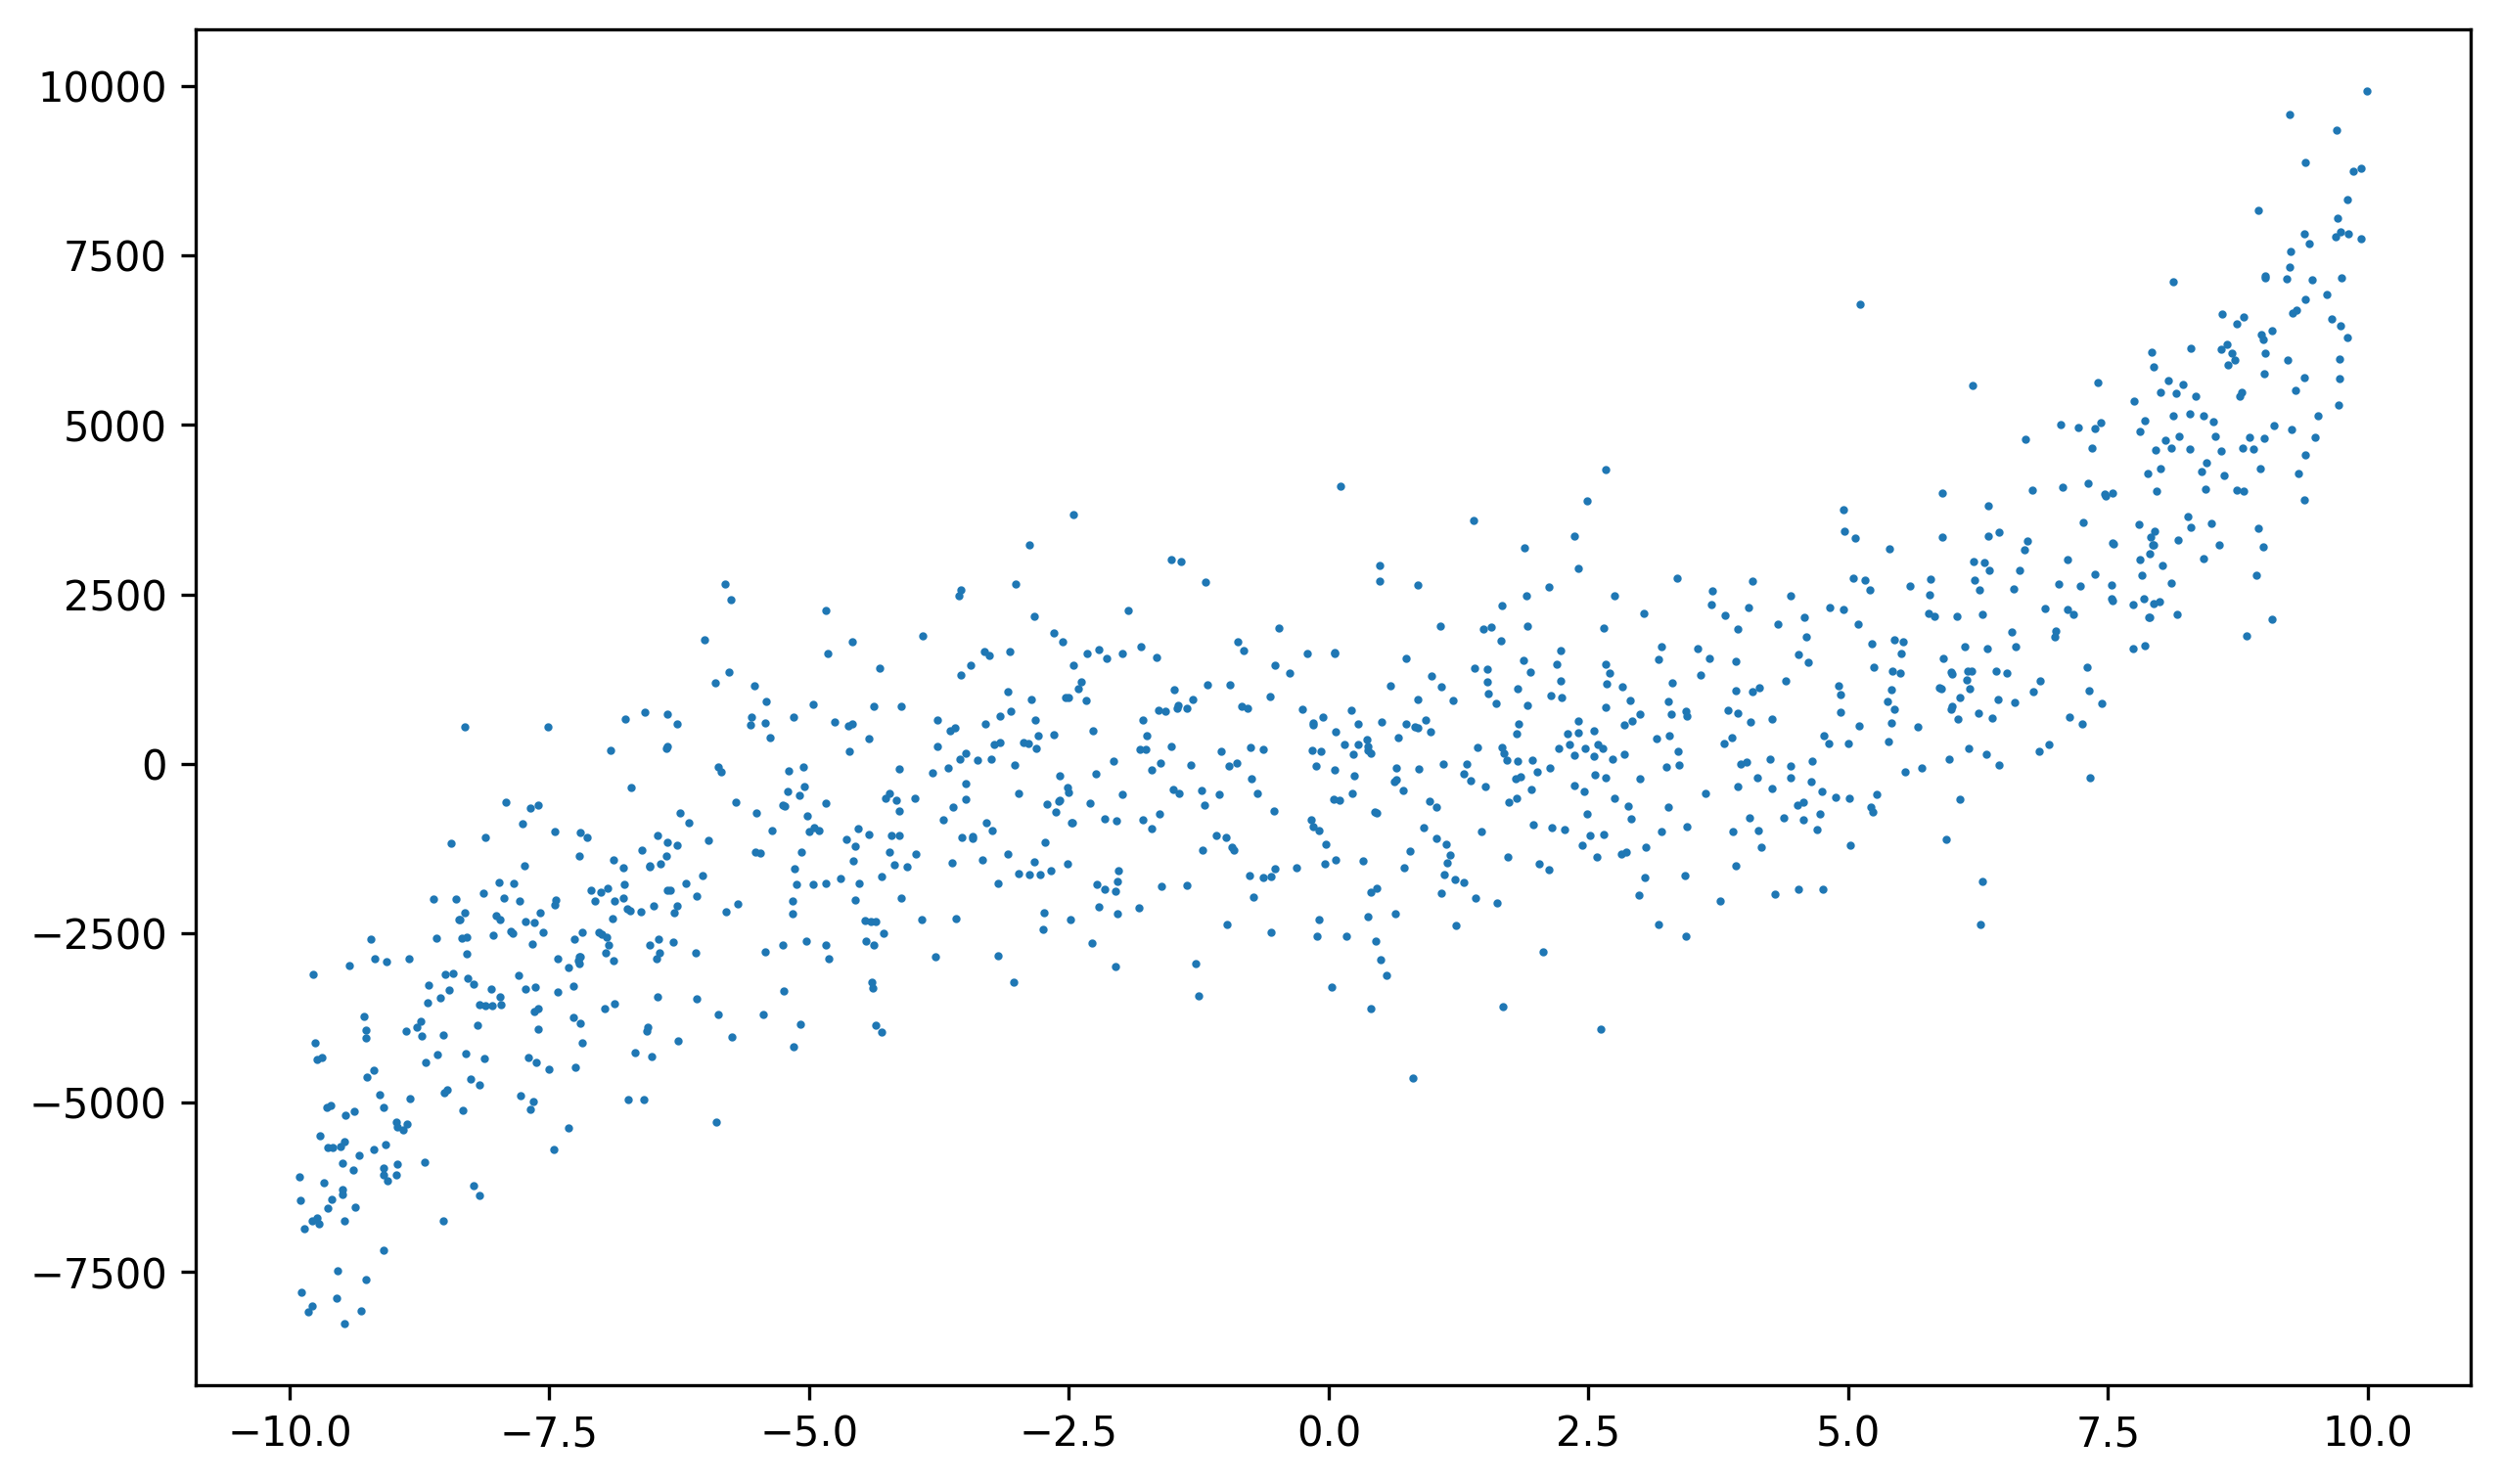

In [58]:
fig, ax = plt.subplots(1, figsize = (10,6), dpi = 300)
ax.scatter(x,y,s=1)

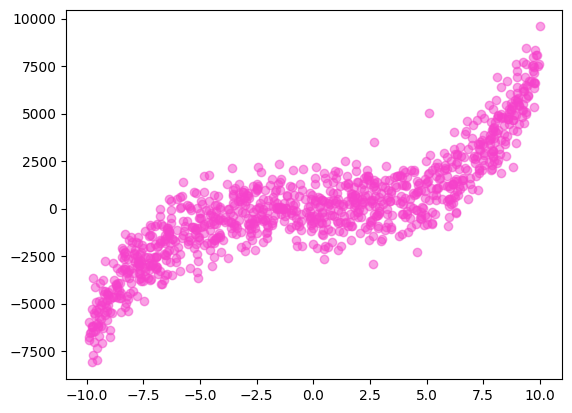

In [49]:
plt.scatter(x=x[:,0], y=y,color='#f542cb', alpha=0.5)
plt.show()

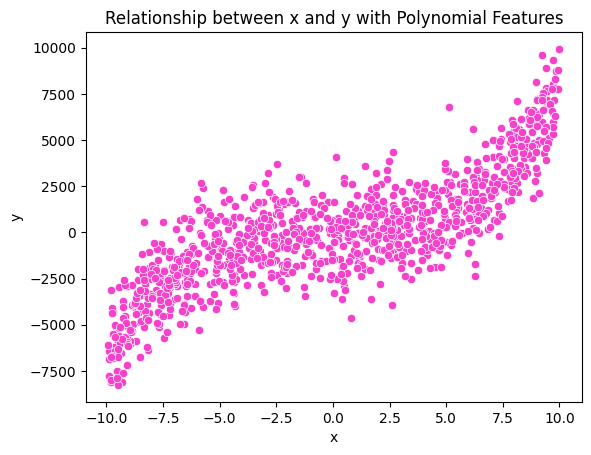

In [59]:
# 1.6 plot relationship btw x and y 
sns.scatterplot(x=x[:,0], y=y,color='#f542cb')
plt.title('Relationship between x and y with Polynomial Features')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

And let's split the data into a training and a test set. We also compute the predictions of the *true* model on the test set, as we will need this to compute the bias.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, train_size=.5)
y_pred_true = np.sum(X_test*betas, axis=1)

### Step 2 - Computing bias and Variance
Let's start from implementing our definitions of variance and biases into functions

In [92]:
import pandas as pd

results_df = pd.DataFrame() # empty df to store result

demboots = 1000
bs_preds = np.zeros((X_test.shape[0],demboots)) 

for i, boot in enumerate(range(demboots)):
    # take a random sample of the training data (1/2 the size of the training set)
    X_train_boot, __ , y_train_boot, __ = train_test_split(X_train[:,1], y_train, train_size=.5, random_state = 1) 
    # fiting a LinearRegression on the sampled data
    model = LinearRegression().fit(X_train_boot.reshape(-1,1), y_train_boot) # initialising the model 
    
    # predict for all test data points 
    bs_preds[:,i] = model.predict(X_test[:,1].reshape(-1,1))


In [104]:
bootstrap_mean = np.mean(bs_preds, axis = 1)
squared_bias = (y_test - bootstrap_mean)**2

print(bootstrap_mean.shape)
print(f"The mean squared bias is: {np.mean(squared_bias)}")
print(f"The variance is: {bs_preds.var(axis=1).mean()}")

(500,)
The mean squared bias is: 3450332.4807701157
The variance is: 3.2794793291239133e-25


In [55]:
def _compute_bias(pred, true):
    ''' Function to compute bias. 
        Note that here we compute the average squared bias of the model
        over all data points to get a sense for its tendency to make 
        systematically "off-target" predictions.

    Args:
        pred (np.array): array of shape (n_samples, n_bootstrap), where n_samples is the size
            of the test set, and n_bootstraps is how many times we sample data from the training
            set and fit our model
        true (np.array): predictions of the true model. It is an array of shape (n_samples)
    '''
    mpred = pred.mean(axis=1)
    return (((true - mpred)**2)).mean()


In [25]:
def _compute_variance(pred):
    ''' Function to compute variance
    Args:
        pred (np.array): array of shape (n_samples, n_bootstrap), where n_samples is the size
            of the test set, and n_bootstraps is how many times we sample data from the training
            set and fit our model
    '''
    return pred.var(axis=1).mean()

Next, let's compute bias and variance (and MSE) for bootstrapped linear models, with an increasing amount of polynomial expansions of x as input features!

In [26]:
max_degree = 10 # this defines the most complex model we will fit (with x, ..., x^10) as inputs
n_sim = 1000 # this defines how many times we do bootstrapping
performances = [] # here we will store performances
results = [] # here we store performances as a DF (see logic in the loop)
outputs = ['mtype', # this is the information we want to store in the DF
           'complexity', 
           'bias^2', 
           'variance', 
           'mse']

for c in range(1, max_degree):
    reg = LinearRegression() # initialize the model 
    pred_all = np.zeros(shape=(y_test.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps
    for sim in range(n_sim): # bootstrap n_sim times
        x, _, y, _ = train_test_split(X_train, y_train, train_size=.5) # sample half of the data
        transformer = PolynomialFeatures(degree=c)
        x_fit = transformer.fit_transform(x[:,1].reshape(-1,1)) # take x, and add all polynomials all the way to c (current complexity)
        x_test = transformer.fit_transform(X_test[:,1].reshape(-1,1)) # do the same with the test set
        reg.fit(x_fit,y) # fit the model
        preds = reg.predict(x_test) # predict the outcomes
        pred_all[:,sim] = preds # store that in the big result matrix

    # once we are done bootstrapping, we have predictions for all models
    mse = np.mean([np.sqrt(mean_squared_error(y_test, 
                                              pred_all[:,sim])) # compute the average MSE of the models
                    for sim in range(n_sim)])
    bias = _compute_bias(pred_all, y_pred_true) # get bias
    variance = _compute_variance(pred_all) # get variance
    info = ('linear', x_fit.shape[1]-1, bias, variance, mse)
    performances.append(info) # append model info to performances

# Getting the results into a dataframe 
result = pd.DataFrame(performances, columns=outputs)
for c in ['bias^2', 'variance', 'mse']:
    result[f'{c}-scaled'] = MinMaxScaler().fit_transform(result[c].values.reshape(-1,1)) # rescale, so bias and variance are on the same scale
results.append(result)
performances = []

Time to visualize our results

In [27]:
data = pd.concat(results)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

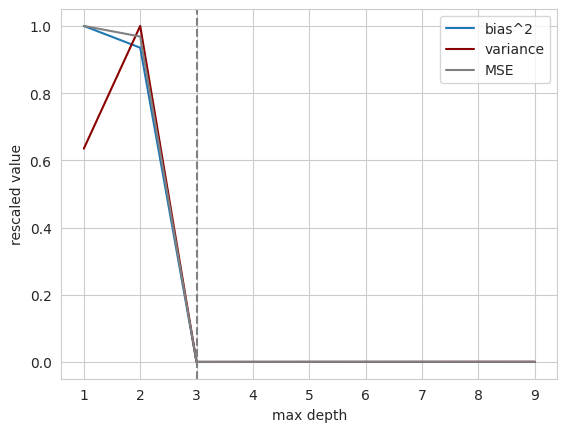

In [ ]:
sns.lineplot(data=data, x='complexity', y='bias^2-scaled', label='bias^2')
sns.lineplot(data=data, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=data, x='complexity', y='mse-scaled', label='MSE', color='grey')
plt.xlabel('max depth')
plt.ylabel('rescaled value')
plt.axvline(x=data.iloc[data['mse'].argmin()]['complexity'], 
            linestyle='--',
            color='grey')
plt.show()

There we go! The optimal model (error-wise) is one with polynomial expansions all the way to $x^3$ (as expected!).
Note that, models simpler than that have both high variance and high bias. While complexity > 3 further reduces bias or has no effect, variance increases, making our model increasingly unrealiable (and, if we compared train and test performance, we would see good evidence of overfitting.)

### Extra: Decision Tree
Same code as above, this time with a decision tree with varying maximum depth.

In [28]:
max_depth = 20 # this defines the most complex model we will fit (with x, ..., x^10) as inputs
n_sim = 1000 # this defines how many times we do bootstrapping
performances = [] # here we will store performances
results = [] # here we store performances as a DF (see logic in the loop)
outputs = ['mtype', # this is the information we want to store in the DF
           'complexity', 
           'bias^2', 
           'variance', 
           'mse']

for c in range(1, max_depth):
    reg = DecisionTreeRegressor(max_depth=c) # initialize the model 
    pred_all = np.zeros(shape=(y_test.shape[0], n_sim)) # empty array, which will store our predictions across bootstraps
    for sim in range(n_sim): # bootstrap n_sim times
        x, _, y, _ = train_test_split(X_train, y_train, train_size=.5) # sample half of the data
        reg.fit(x,y) # fit the model
        preds = reg.predict(X_test) # predict the outcomes
        pred_all[:,sim] = preds # store that in the big result matrix

    # once we are done bootstrapping, we have predictions for all models
    mse = np.mean([np.sqrt(mean_squared_error(y_test, 
                                              pred_all[:,sim])) # compute the average MSE of the models
                    for sim in range(n_sim)])
    bias = _compute_bias(pred_all, y_pred_true) # get bias
    variance = _compute_variance(pred_all) # get variance
    info = ('tree', c, bias, variance, mse)
    performances.append(info) # append model info to performances

# Getting the results into a dataframe 
result = pd.DataFrame(performances, columns=outputs)
for c in ['bias^2', 'variance', 'mse']:
    result[f'{c}-scaled'] = MinMaxScaler().fit_transform(result[c].values.reshape(-1,1)) # rescale, so bias and variance are on the same scale
results.append(result)
performances = []

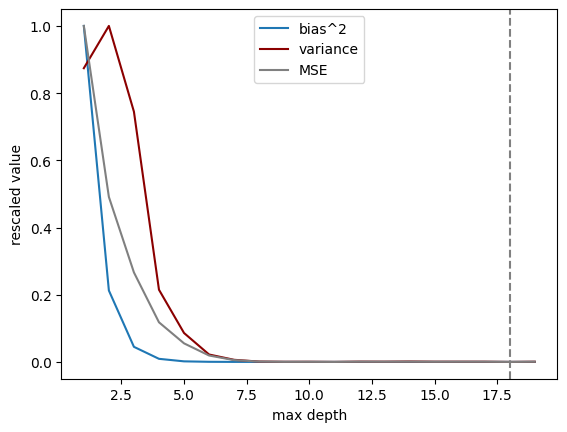

In [30]:
data = pd.concat(results)
sns.lineplot(data=data, x='complexity', y='bias^2-scaled', label='bias^2')
sns.lineplot(data=data, x='complexity', y='variance-scaled', label='variance', color='darkred')
sns.lineplot(data=data, x='complexity', y='mse-scaled', label='MSE', color='grey')
plt.xlabel('max depth')
plt.ylabel('rescaled value')
plt.axvline(x=data.iloc[data['mse'].argmin()]['complexity'], 
            linestyle='--',
            color='grey')
plt.show()

We see a similar dynamics as before, with models with max_depth < 5 performing very, very poorly (both underfitting, and having high variance). The best models are found at `max_depth=5`, and for higher complexity very low or no gains in bias are accompanied by substantial increases in variance.

### Bonus: fitting a tree-based model
Here is just a snippet showing how you can select the best decision tree (or in general, the best parameters for an estimator) using `GridSearchCV`, as well as some utils to visualize decision trees.

In [31]:
parameters = {'max_depth': range(1,10), 
              'min_samples_split': np.arange(1,100,10),
              'ccp_alpha': [0.01, 0.1, 1.0, 10.0]}

clf = GridSearchCV(DecisionTreeRegressor(), 
                   parameters, 
                   n_jobs=1, 
                   scoring='neg_mean_squared_error', 
                   cv=5)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print(clf.best_params_) 

predicted = tree_model.predict(X_test)
print('test RMSE: ', np.sqrt(mean_squared_error(y_test, 
                                                predicted)))

{'ccp_alpha': 0.01, 'max_depth': 9, 'min_samples_split': 11}
test RMSE:  60.66342125528851


/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
180 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/work/EmmaRisgaardOlsen#9993/ds-env/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_pa

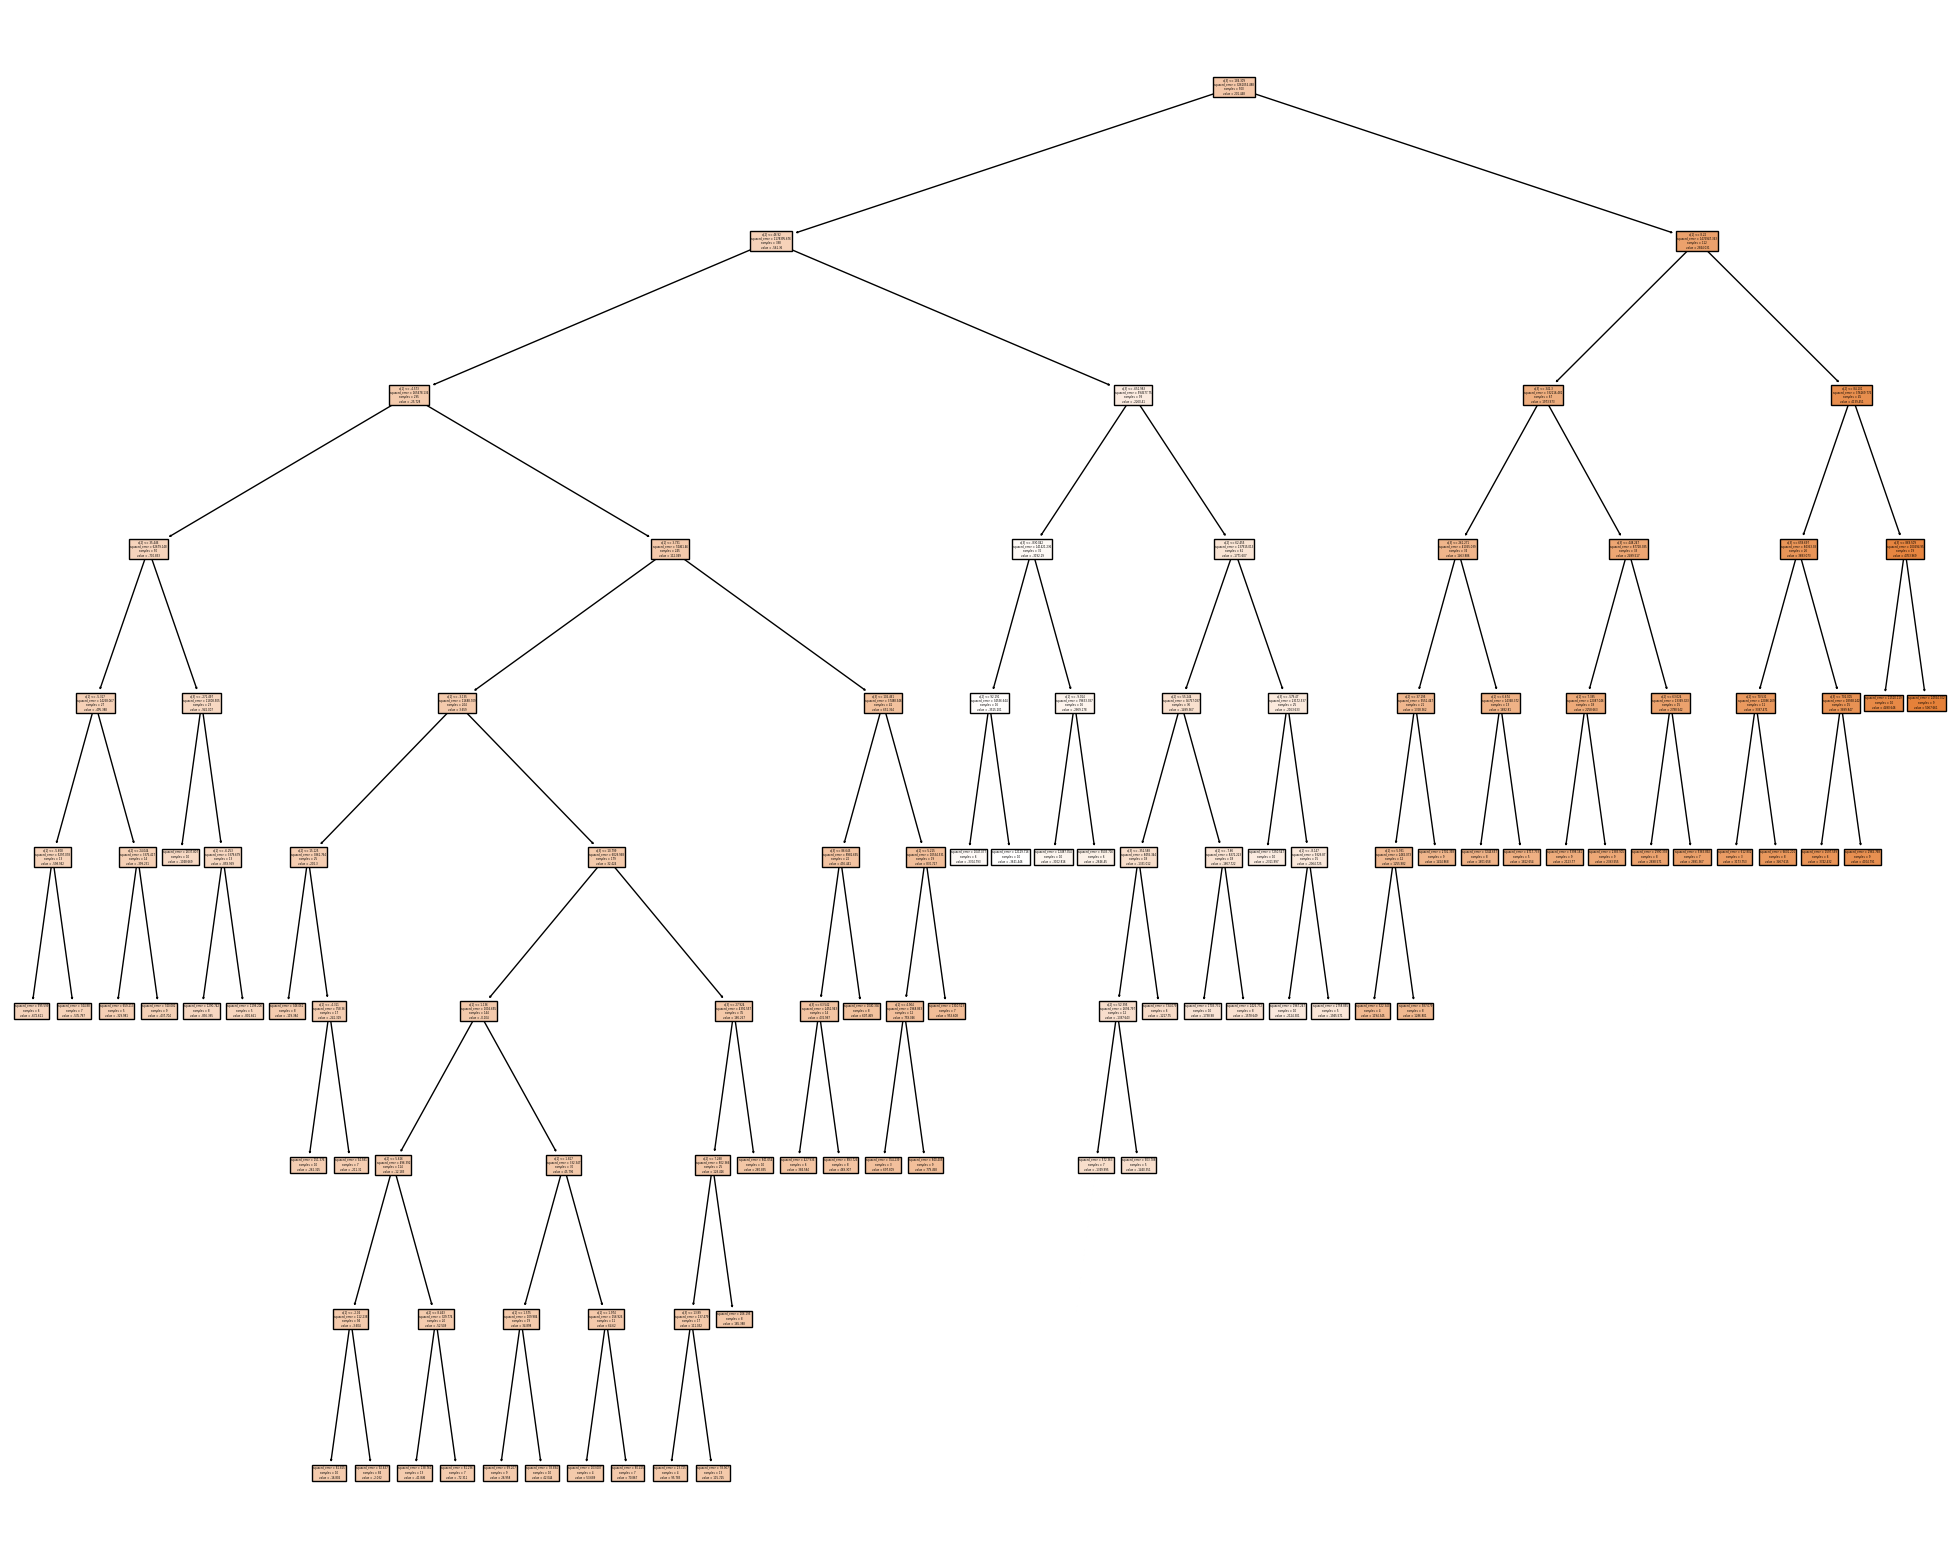

In [32]:
fig = plt.figure(figsize=(25,20))
_ = tr.plot_tree(tree_model, 
                 filled=True)